# GMVPredict: A Pre-Trained Model for Pre-Morbid GMV Estimation 
William Yang<sup>1*</sup>, Petar Raykov<sup>1</sup>, Andrea Greve<sup>1</sup>
> <sup>1</sup>MRC Cognition and Brain Sciences Unit, University of Cambridge \
> <sup>*</sup>Correspondence: wy279@cam.ac.uk

**Note**: This Jupyter notebook is based on non-production code for educational purposes, which aim to illustrate the process of developing and implementing GMVPredict.



---
## 1 Setup

### 1.1 Package Loading

In [388]:
# @title 1.1 Package Loading

# Load Packages
import numpy as np
from numpy import arange
from numpy import sqrt
import pandas as pd
import joblib
import pickle
import os
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.svm import LinearSVR, LinearSVC, SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA, KernelPCA
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scipy.stats import pearsonr, mannwhitneyu, norm, zscore
import shap
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import warnings
from numba import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

# Suppress NumbaDeprecationWarning and NumbaPendingDeprecationWarning
warnings.filterwarnings('ignore', category=NumbaDeprecationWarning)
warnings.filterwarnings('ignore', category=NumbaPendingDeprecationWarning)

### 1.2 Helper Functions

In [389]:
def continuous_predict(search, data):
    y_pred = search.predict(data)
    y_pred = y_train_mean + y_train_std*y_pred
    y_pred = np.clip(y_pred,0,None)

    return y_pred

def impute_continuous_data(X_train, X_CV, continuous_missing, impute_method='mean', knn_neighbors=None):
    if impute_method == 'mean':
        # Mean imputation for continuous variables
        imputer = SimpleImputer(strategy='mean')
    elif impute_method == 'knn':
        # KNN imputation for continuous variables
        imputer = KNNImputer(n_neighbors=knn_neighbors)
    else:
        raise ValueError("Invalid imputation method. Choose either 'mean' or 'knn'.")

    # Fitting and transforming the training data
    X_train[continuous_missing] = imputer.fit_transform(X_train[continuous_missing])
    # Transforming the validation data
    X_CV[continuous_missing] = imputer.transform(X_CV[continuous_missing])

    return X_train, X_CV

### 1.3 Loading Data

Here, the chosen directory for data is defined. 

In this code a csv file (unprovided) is used which contains demographic and VBM ROI data (708 rows, 118 feature columns). This csv was generated from structural MRI image processing in SPM/MATLAB, and contains subject demographic data (Age, Sex, Education, Income), behavioural data (episodic memory score, cattell IQ score) and average grey matter percentages in 111 ROIs. 

In [390]:
# Define source file (this file contains subject data)
source_directory = 'Source/MeanGrayVBM.csv'

# Define atlas voxel file (this file contains the number of voxels in each ROI per the atlas used)
atlasvoxel_directory = 'Source/Nvoxel_table.csv'

# Load Raw Data
raw_df = pd.read_csv(source_directory, sep=',', header=0, index_col=0) # Dataframe with demographic and VBM ROI data (708 rows, 118 feature columns)

---
## 2 Data Preprocessing & Cleaning

In [391]:
# Re-map sex values such that 1 = male, 0 = female (in the csv generated from SPM, it was 1 and 2)
raw_df['Sex'] = raw_df['Sex'].replace({2: 0})

# Verifying all GMV values of R hippocampus (108) have accompanying values for L hippocampus (101)
mask_101 = raw_df['ROI_101'].notna()
mask_108 = raw_df['ROI_108'].isna()
problem_rows = raw_df[mask_101 & mask_108] # This is empty, so there are no problem rows

# Dropping rows with no hippocampal GMV
df = raw_df.dropna(subset=['ROI_101']).copy()

# Adjust dataset to include total GM volume instead of average across ROI (i.e. percentage GM)
nvoxels = pd.read_csv(atlasvoxel_directory, sep=',', header=0, index_col=False) # Dataframe with number of voxels in each ROI
roi_columns = [col for col in raw_df.columns if 'ROI_' in col] # Selecting only the ROI volume columns and not age, sex etc
multiplier = nvoxels[roi_columns].iloc[0]
df[roi_columns] = df[roi_columns].mul(multiplier)

# Adding R hippocampus and L hippocampus volumes to make one outcome variable column
df['HippGMV'] = df['ROI_101'] + df['ROI_108']

# De-fragmenting the dataframe
df = df.copy()

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Here, we define the target variable to be 'HippGMV', the total grey matter volume of the hippocampus

---
## 3 Exploratory Data Analysis

### 3.1 Top Features Correlated with HippGMV

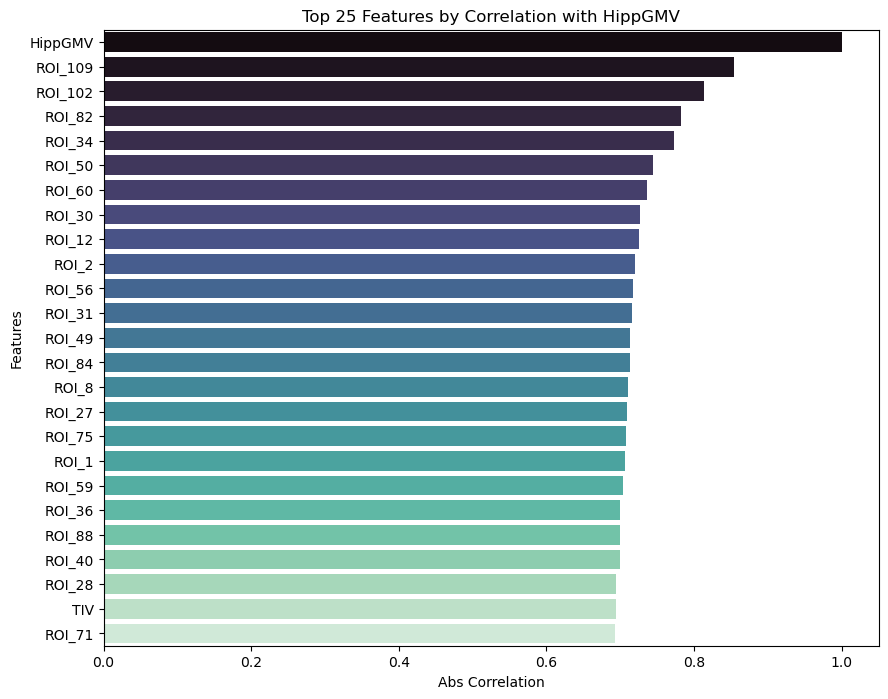

In [392]:
# Correlation matrix
df_dropped = df.drop(columns=['ROI_101', 'ROI_108']).dropna()
corr_matrix = df_dropped.corr()
corr_with_HippGMV = corr_matrix['HippGMV']

# Select top n features
top_N = 25  # Choose n
top_corr_with_HippGMV = corr_with_HippGMV.apply(abs).sort_values(ascending=False).head(top_N)

# Bar chart of top n features
plt.figure(figsize=(10, 8))
sns.barplot(x=top_corr_with_HippGMV.values, y=top_corr_with_HippGMV.index, palette='mako')
plt.title(f'Top {top_N} Features by Correlation with HippGMV')
plt.xlabel('Abs Correlation')
plt.ylabel('Features')
plt.show()

### 3.2 Top Features Correlated with HippGMV (Regressing Out Age/Sex/TIV) 

Here, we regress out features from the 'basic' model of Age, Sex and total intracranial volume (TIV) to obtain residuals of the ROI data

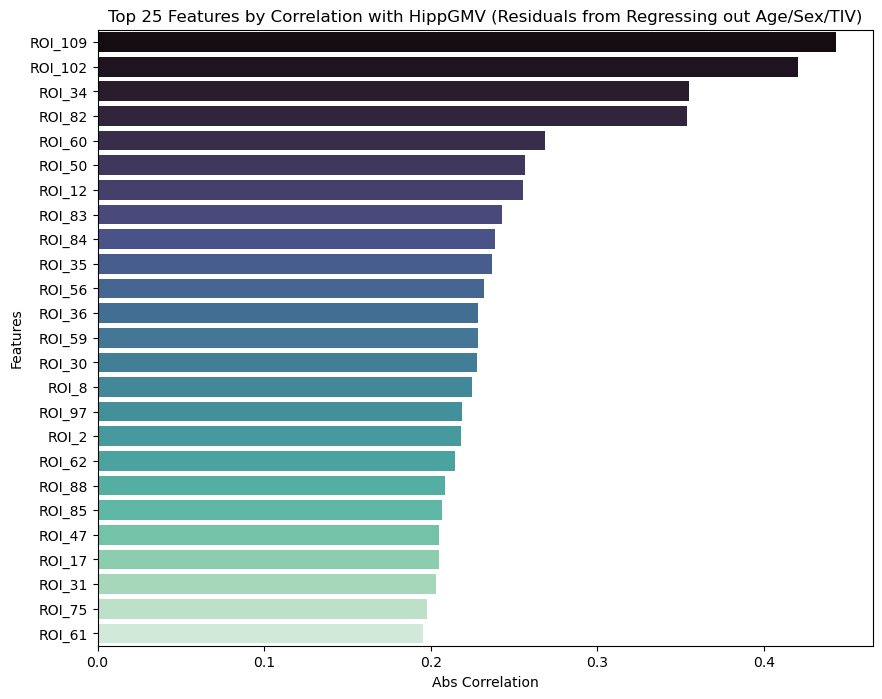

In [393]:
# Multiple linear regression to estimate relationship between each ROI vs. age/sex/TIV
base_features = ['Age', 'Sex', 'TIV']
X_reduced = df_dropped[base_features]
X_reduced = sm.add_constant(X_reduced)

# Prepare the target variable
y_reduced = df_dropped[['HippGMV']]

# Create a dictionary to store the residuals for each ROI
residuals_dict = {}

# Iterate over the columns starting with "ROI"
for column in df_dropped.columns:
    if column.startswith('ROI') and column not in ['Age', 'Sex', 'TIV', 'cattell', 'EM', 'Income', 'Education', 'ROI_101', 'ROI_108']:
        roi_column = df_dropped[column]

        # Fit the multiple linear regression model
        model = sm.OLS(roi_column, X_reduced)
        results = model.fit()

        # Obtain the residuals from the regression
        residuals = results.resid

        # Store the residuals in the dictionary using the column name as the key
        residuals_dict[column] = residuals

# Convert the residuals dictionary to a DataFrame
residuals_df = pd.DataFrame(residuals_dict)

# Compute pairwise correlations between residuals of each ROI vs. HippGMV
corr_with_HippGMV_residuals = {}
for roi_column in residuals_df.columns:
    # Perform correlation between residuals and HippGMV
    corr = np.corrcoef(residuals_df[roi_column], df_dropped['HippGMV'])[0, 1]
    corr_with_HippGMV_residuals[roi_column] = corr

# Convert the correlations to a pandas Series
corr_with_HippGMV_residuals = pd.Series(corr_with_HippGMV_residuals)

# Select top n features
top_corr_with_HippGMV_residuals = corr_with_HippGMV_residuals.apply(abs).sort_values(ascending=False).head(top_N)

# Bar chart of top n features
plt.figure(figsize=(10, 8))
sns.barplot(x=top_corr_with_HippGMV_residuals.values, y=top_corr_with_HippGMV_residuals.index, palette='mako')
plt.title(f'Top {top_N} Features by Correlation with HippGMV (Residuals from Regressing out Age/Sex/TIV)')
plt.xlabel('Abs Correlation')
plt.ylabel('Features')
plt.show()

### 3.3 Plotting Histogram of Feature Correlation

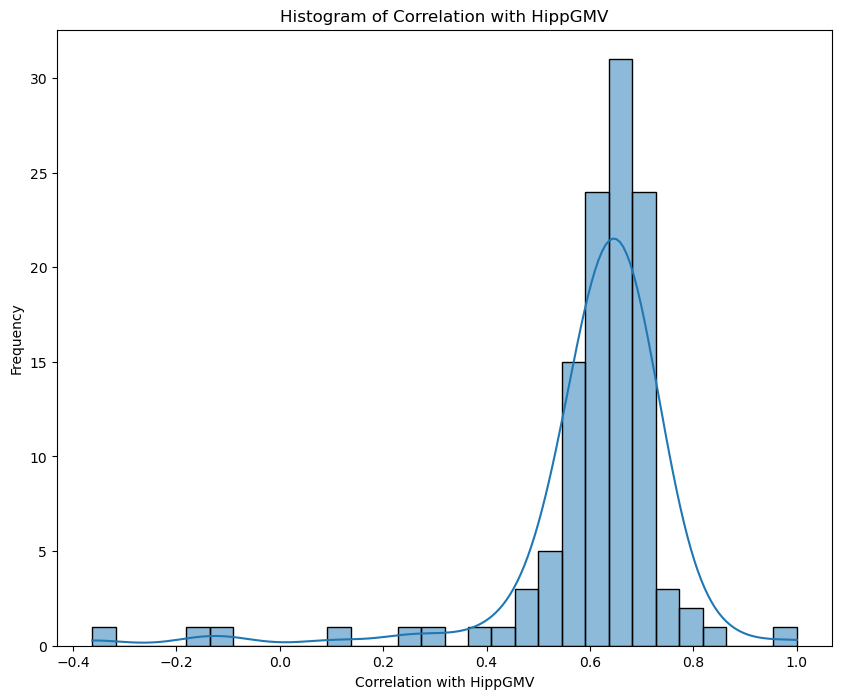

In [394]:
# Histogram of feature correlations
plt.figure(figsize=(10, 8))
sns.histplot(corr_with_HippGMV.values, bins=30, kde=True)
plt.xlabel('Correlation with HippGMV')
plt.ylabel('Frequency')
plt.title('Histogram of Correlation with HippGMV')
plt.show()

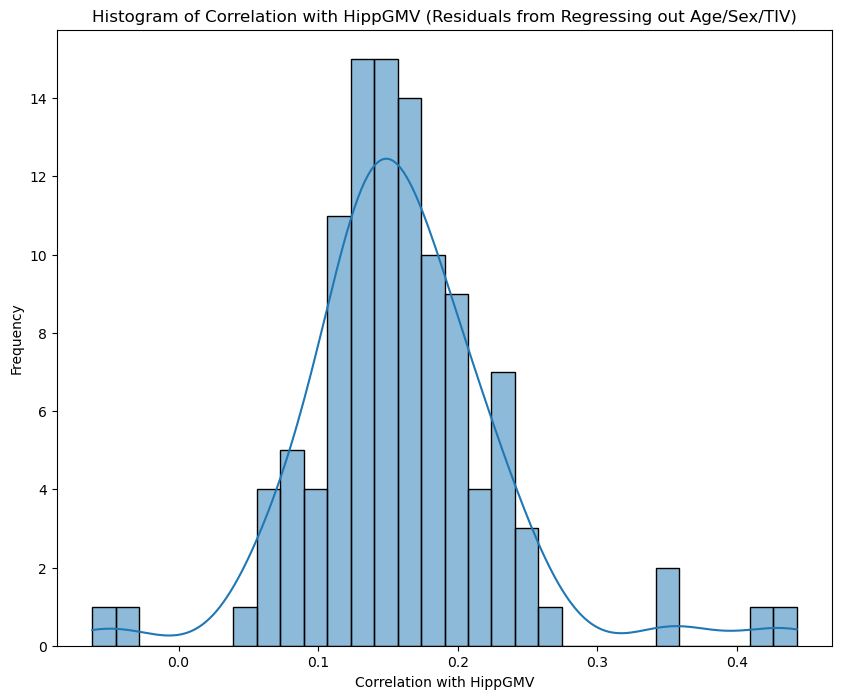

In [395]:
# Histogram of residuals 
plt.figure(figsize=(10, 8))
sns.histplot(corr_with_HippGMV_residuals.values, bins=30, kde=True)
plt.xlabel('Correlation with HippGMV')
plt.ylabel('Frequency')
plt.title('Histogram of Correlation with HippGMV (Residuals from Regressing out Age/Sex/TIV)')
plt.show()

---
## 4 Feature Selection

In [396]:
df_full = df.dropna() # df_full preserves all features (behavioral, demographic, GMV), then drops missing values. 597 rows.
df_noincome = df.drop(columns=['Income']) # df_noincome preserves all features except Income, then drops missing values. 626 rows. HippGMV and income (see Farah, 2017)
df_nobehav_noincome = df.drop(columns=['cattell', 'EM', 'Income']) # df_nobehav preserves all features except cattell IQ, episodic memory, and income, then drops rest. 616 rows
df_restrict = df.drop(columns=['cattell', 'EM', 'Education', 'Income']).dropna().drop(columns=['TIV']) # df_restrict datset only includes age, sex and MRI features. 648 rows after dropping missing values.

# TOGGLE: df_select globally determines which df is used
df_select = df_restrict

At this stage, the df has 653 rows and 118 features, which reduces depending on whether behavioral and demographic features are dropped. These features contain many missing values which can be dropped or imputed. In this example, we drop behavioural data as well as all demographic data except age and sex. 

---
## 5 Train-Validation Split

In [397]:
targets = ['HippGMV'] # Can change or add more if needed, but make sure to edit feature_columns accordingly

# Defining features to be excluded from training. By default we exclude L, R and HippGMV
feature_exclusion = targets.copy()
if 'HippGMV' in targets:
    for roi in ['ROI_101', 'ROI_108']: # Note HippGMV = ROI_101 + ROI_108
        if roi not in feature_exclusion:
            feature_exclusion.append(roi)

# Excluding L, R and bilateral hippocampal GMV from training
feature_columns = [col for col in df_select.columns if col not in feature_exclusion] 
X = df_select[feature_columns]
y = df_select[targets]

# Splitting data
X_train, X_CV, y_train, y_CV = train_test_split(X, y, test_size=0.2, random_state=0)

Here, the targets list can be edited to predict other features, or to predict more features. When this is done, the feature_columns list must be edited such that they exclude the targets list.

---
## 6 Feature Engineering

### 6.1 Imputation Flag

In [398]:
# Identifying columns with missing values in the training set
missing_cols_train = X_train.columns[X_train.isnull().any()].tolist()

# Adding indicator feature (imputation flag) to the training set
if len(missing_cols_train) > 0:
    X_train = X_train.copy()
    X_train['impute'] = X_train[missing_cols_train].isnull().astype(int)

# Identifying columns with missing values in the validation set
missing_cols_CV = X_CV.columns[X_CV.isnull().any()].tolist()

# Adding an indicator feature (imputation flag) to the validation set
if len(missing_cols_CV) > 0:
    X_CV = X_CV.copy()
    X_CV['impute'] = X_CV[missing_cols_CV].isnull().astype(int)

### 6.2 Polynomial Transformation

In [399]:
# Squaring age in the X datasets, due to evidence of a quadratic relationship between age and GMV
X_train['Age_squared'] = X_train['Age']**2
X_train.insert(0, 'Age_squared', X_train.pop('Age_squared'))
X_CV['Age_squared'] = X_CV['Age']**2
X_CV.insert(0, 'Age_squared', X_CV.pop('Age_squared'))

### 6.3 Imputation via K-Nearest Neighbors Method

In [400]:
# Defining ordinal and continuous columns with missing values
continuous_missing = []
X_train_cont = X_train[continuous_missing]

# Initialize results list
knn_cv_scores = []

# Define the range of neighbors to be tested
neighbors = list(range(1, 20))

if continuous_missing:
    # Cross-validation for KNN Imputer based on the number of neighbors
    for k in neighbors:
        
        # Initialize KNN Imputer with the current number of neighbors
        imputer = KNNImputer(n_neighbors=k)
        
        # Fit the imputer on the training data and transform both training and CV datasets
        X_train_imputed = imputer.fit_transform(X_train[continuous_missing])
        X_CV_imputed = imputer.transform(X_CV[continuous_missing])
        
        # Use XGBoost as the model for CV
        model = XGBRegressor()
        scores = cross_val_score(model, X_train_imputed, y_train, cv=5, scoring='neg_mean_squared_error')
        
        # Append the mean score to the results list
        knn_cv_scores.append(scores.mean())

    # Calculate RMSE for each number of neighbors
    rmse_scores = [sqrt(abs(score)) for score in knn_cv_scores]

    # Find the number of neighbors giving the smallest RMSE
    optimal_k = neighbors[rmse_scores.index(min(rmse_scores))]

    # Perform the final imputation using the optimal number of neighbors
    final_imputer = KNNImputer(n_neighbors=optimal_k)
    X_train[continuous_missing] = final_imputer.fit_transform(X_train[continuous_missing])
    X_CV[continuous_missing] = final_imputer.transform(X_CV[continuous_missing])

### 6.4 Pickling Train/Test Data

In [401]:
# Ensuring no missing values left 
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_CV = X_CV.dropna()
y_CV = y_CV.loc[X_CV.index]

# Copying data
X_train_main = X_train.copy()
y_train_main = y_train.copy()
X_CV_main = X_CV.copy()
y_CV_main = y_CV.copy()

# Pickling train-validation data
if os.path.exists('Models') == False: os.makedirs('Models')
pickle.dump(X_train_main, open('Models/X_train_main.pkl', 'wb'))
pickle.dump(y_train_main, open('Models/y_train_main.pkl', 'wb'))
pickle.dump(X_CV_main, open('Models/X_CV_main.pkl', 'wb'))
pickle.dump(y_CV_main, open('Models/y_CV_main.pkl', 'wb'))

---
## 7 Baseline Models

### 7.1 Training Baseline Models

In [402]:
# Open train-validation data
X_train_main = pickle.load(open('Models/X_train_main.pkl','rb'))
y_train_main = pickle.load(open('Models/y_train_main.pkl','rb'))
# y_train_main = y_train_main.to_frame()
X_CV_main = pickle.load(open('Models/X_CV_main.pkl','rb'))
y_CV_main = pickle.load(open('Models/y_CV_main.pkl','rb'))
# y_CV_main = y_CV_main.to_frame()

# Training baseline models
if os.path.exists('Models/baselines') == False: os.makedirs('Models/baselines')

for target in targets:    
    # Ensuring missing values are dropped before training
    y_train = y_train_main[target]
    X_train = X_train_main.loc[y_train.index.values]

    # Z-score standardization of y variable
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train_trans = (y_train-y_train_mean)/y_train_std
    y_train = y_train_trans
    
    models = [LinearRegression(), Lasso(random_state = 0), Ridge(random_state = 0), ElasticNet(random_state = 0), RandomForestRegressor(random_state = 0), XGBRegressor(), SVR()]
    for model in tqdm(models):
        model.fit(X_train, y_train)
        model_name = model.__class__.__name__ # Retrieves model class name to make file name shorter (needed for XGBoost)
        try:
            if (type(model).__name__ == 'XGBRegressor'): fname = f'Models/baselines/{target}_{model_name}.pkl'
            else: fname = f'Models/baselines/{target} {str(model)}.pkl'
        except:
            continue
        joblib.dump(model, fname)

100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


### 7.2 Baseline Model Results

In [403]:
results_baseline = pd.DataFrame()
# y = y.to_frame()

for target in targets:
    # Ensuring missing values are dropped before training
    y_train = y_train_main[target]
    X_train = X_train_main.loc[y_train.index.values]

    vars = []
    model_type = []
    train_r2 = []
    cv_r2 = []
    train_rmse = []
    cv_rmse = []
    n_features = []
    
    models = [LinearRegression(), Lasso(random_state = 0), Ridge(random_state = 0), ElasticNet(random_state = 0), RandomForestRegressor(random_state = 0), XGBRegressor(), SVR()]
    for model in models:
        model_name = model.__class__.__name__ # Retrieves model class name to make file name shorter (needed for XGBoost)
        try:
            if (type(model).__name__ == 'XGBRegressor'): model = joblib.load(f'Models/baselines/{target}_{model_name}.pkl')
            else: model = joblib.load(f'Models/baselines/{target} {str(model)}.pkl')
        except:
            continue

        vars.append(target)
        model_type.append(type(model).__name__)

        y_pred = continuous_predict(model, X_train)
        train_r2.append(r2_score(y_train, y_pred))
        train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred)))

        y_pred = continuous_predict(model, X_CV)
        cv_r2.append(r2_score(y_CV, y_pred))
        cv_rmse.append(np.sqrt(mean_squared_error(y_CV, y_pred)))

    results_baseline2 = pd.DataFrame({'variable': vars, 'model': model_type, 'train_r2': train_r2, 'cv_r2': cv_r2, 'train_rmse': train_rmse, 'cv_rmse': cv_rmse})
    results_baseline = pd.concat([results_baseline, results_baseline2], axis=0).reset_index(drop=True)
results_baseline = results_baseline.round(3)
results_baseline


,variable,model,train_r2,cv_r2,train_rmse,cv_rmse
0,HippGMV,LinearRegression,0.857,0.764,36.082,46.539
1,HippGMV,Lasso,0.814,0.773,41.052,45.699
2,HippGMV,Ridge,0.857,0.764,36.083,46.540
3,HippGMV,ElasticNet,0.834,0.782,38.812,44.795
4,HippGMV,RandomForestRegressor,0.964,0.740,18.108,48.922
5,HippGMV,XGBRegressor,1.000,0.718,0.043,50.945
6,HippGMV,SVR,0.658,0.694,55.738,53.090


---
## 8 Hyperparameter Optimization

### 8.1 Tuning with Bayesian Search

In [404]:
bayestune_iter = 10 # Setting number of iterations for Bayesian search

# Set directory for pickling Bayesian Search model
if os.path.exists('Models/bayesiansearch') == False: os.makedirs('Models/bayesiansearch')

for target in targets:
    # Ensuring missing values are dropped before training
    y_train = y_train_main[target].dropna()
    X_train = X_train_main.loc[y_train.index.values]

    # Z-score standardization of y variable 
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train_trans = (y_train-y_train_mean)/y_train_std
    y_train = y_train_trans

    # Initialize preprocessing objects
    cols = list(X_train.columns)
    preprocessor = ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough')
    skb = SelectKBest(score_func=mutual_info_regression)

    # Initialize estimators
    model1 = ElasticNet(random_state = 0)
    model2 = XGBRegressor()
    model3 = RandomForestRegressor(random_state = 0)

    # Create pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('skb', skb), ('model', model1)])
    
    # Initialize hyperparameters for elasticnet
    param1 = {}
    param1['preprocessor__standard'] = Categorical([ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')])
    param1['skb__k'] = Integer(10, len(X_train.columns), "log-uniform")
    param1['model__alpha'] = Real(0.001, 10)
    param1['model__l1_ratio'] = Real(0, 1)
    param1['model'] = Categorical([model1])

    # Run Bayesian Search for elasticnet
    params = [param1]
    search = BayesSearchCV(pipe, params, scoring='neg_mean_squared_error', cv = 3, verbose = 1, n_iter = bayestune_iter, n_jobs = -1)
    search.fit(X_train, y_train)
    fname = f'Models/bayesiansearch/{target} elasticnet bayesian.pkl'
    joblib.dump(search, fname)

    # Initialize the hyperparameters for XGBoost
    param2 = {}
    param2['preprocessor__standard'] = Categorical([ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')])
    param2['skb__k'] = Integer(10, len(X_train.columns), "log-uniform")
    param2['model__gamma'] = Real(0.001, 10.0)
    param2['model__min_child_weight'] = Integer(1, 20)
    param2['model__learning_rate'] = Real(0.01, 0.3)
    param2['model__colsample_bytree'] = Real(0.4, 0.8)
    param2['model__subsample'] = Real(0.4, 0.8)
    param2['model__n_estimators'] = list(range(50, 1001, 50))
    param2['model__max_depth'] = Integer(1, 10)
    param2['model'] = Categorical([model2])

    # Run Bayesian Search for XGBoost
    params = [param2]
    search = BayesSearchCV(pipe, params, scoring='neg_mean_squared_error', cv = 3, verbose = 1, n_iter = bayestune_iter, n_jobs = -1)
    search.fit(X_train, y_train)
    fname = f'Models/bayesiansearch/{target} xgboost bayesian.pkl'
    joblib.dump(search, fname)

    # Initialize the hyperparameters for randomforest
    param3 = {}
    param3['preprocessor__standard'] = Categorical([ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')])
    param3['skb__k'] = Integer(10, len(X_train.columns), "log-uniform")
    param3['model__max_features'] = Categorical(['sqrt', 'log2'])
    param3['model__n_estimators'] = Integer(100, 1000)
    param3['model__max_depth'] = Integer(1,120)
    param3['model'] = [model3]

    # Run Bayesian Search for randomforest
    params = [param3]
    search = BayesSearchCV(pipe, params, scoring='neg_mean_squared_error', cv = 3, verbose = 1, n_iter = bayestune_iter, n_jobs = -1)
    search.fit(X_train, y_train)
    fname = f'Models/bayesiansearch/{target} randomforest bayesian.pkl'
    joblib.dump(search, fname)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/williamyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.862e+00, tolerance: 3.287e-02
  model = cd_fast.enet_coordinate_descent(
/Users/williamyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.303e+00, tolerance: 3.543e-02
  model = cd_fast.enet_coordinate_descent(
/Users/williamyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/williamyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.595e-01, tolerance: 3.504e-02
  model = cd_fast.enet_coordinate_descent(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.467e+00, tolerance: 5.170e-02


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

### 8.2 Tuning with Randomized Search

In [405]:
randomtune_iter = 10 # Setting number of iterations for Randomized search

# Set directory for pickling Randomized Search models
if os.path.exists('Models/randomizedsearch') == False: os.makedirs('Models/randomizedsearch')

for target in targets:
    # Ensuring missing values are dropped before training
    y_train = y_train_main[target].dropna()
    X_train = X_train_main.loc[y_train.index.values]

    # Z-score standardization of y variable 
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train_trans = (y_train-y_train_mean)/y_train_std
    y_train = y_train_trans

    # Initialize preprocessing objects
    cols = list(X_train.columns)
    preprocessor = ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough')
    skb = SelectKBest(score_func=mutual_info_regression)

    # Initialize estimators
    model1 = ElasticNet(random_state = 0)
    model2 = XGBRegressor()
    model3 = RandomForestRegressor(random_state = 0)

    # Create pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('skb', skb), ('model', model1)])

    # Initialize hyperparameters for elasticnet
    param1 = {}
    param1['preprocessor__standard'] = [ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')]
    param1['skb__k'] = [35, 40, 45, 50, 55, 60, len(X_train.columns)]
    param1['model__alpha'] = np.logspace(-4, 2, num=10)
    param1['model__l1_ratio'] = arange(0, 1.01, 0.01) 
    param1['model'] = [model1]

    # Run Randomized Search for elasticnet
    params = [param1]
    search = RandomizedSearchCV(pipe, params, n_jobs=-1, scoring='neg_mean_squared_error', cv = 3, verbose = 1, n_iter = randomtune_iter)
    search.fit(X_train, y_train)
    fname = f'Models/randomizedsearch/{target} elasticnet randomized.pkl'
    joblib.dump(search, fname)

    # Initialize the hyperparameters for XGBoost
    param2 = {}
    param2['preprocessor__standard'] = [ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')]
    param2['skb__k'] = [35, 40, 45, 50, 55, 60, len(X_train.columns)]
    param2['model__max_depth'] = np.arange(1, 10, 1)
    param2['model__learning_rate'] = np.arange(0.01, 0.1, 0.01)
    param2['model__subsample'] = np.arange(0.6, 1.0, 0.1)
    param2['model__n_estimators'] = np.arange(100, 1000, 100)
    param2['model'] = [model2]

    # Run Randomized Search for XGBoost
    params = [param2]
    search = RandomizedSearchCV(pipe, params, n_jobs=-1, scoring='neg_mean_squared_error', cv = 3, verbose = 1, n_iter = randomtune_iter)
    search.fit(X_train, y_train)
    fname = f'Models/randomizedsearch/{target} xgboost randomized.pkl'
    joblib.dump(search, fname)

    # Initialize the hyperparameters for randomforest
    param3 = {}
    param3['preprocessor__standard'] = [ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')]
    param3['skb__k'] = [10, 15, 20, 25, 30, 40, 50, 75, len(X_train.columns)]
    param3['model__max_features'] = ['auto', 'sqrt']
    param3['model__n_estimators'] = np.arange(100, 1000, 100)
    param3['model__max_depth'] = np.arange(0, 120, 10)
    param3['model'] = [model3]

    # Run Randomized Search for randomforest
    params = [param3]
    search = RandomizedSearchCV(pipe, params, n_jobs=-1, scoring='neg_mean_squared_error', cv = 3, verbose = 1, n_iter = randomtune_iter)
    search.fit(X_train, y_train)
    fname = f'Models/randomizedsearch/{target} randomforest randomized.pkl'
    joblib.dump(search, fname)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/williamyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e+01, tolerance: 3.543e-02
  model = cd_fast.enet_coordinate_descent(
/Users/williamyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e+01, tolerance: 3.287e-02
  model = cd_fast.enet_coordinate_descent(
/Users/williamyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits



15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/williamyang/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/williamyang/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/williamyang/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/williamyang/anaconda3/lib/python3.10/site-packages/sklearn/base.

### 8.3 Tuning Results

In [406]:
# Results of Hyperoptimization
results_tuned = pd.DataFrame()

for target in targets:
    # Ensuring missing values are dropped before training
    y_train = y_train_main[target].dropna()
    X_train = X_train_main.loc[y_train.index.values]

    # Drop NA for CV
    y_CV = y_CV_main[target].dropna()
    X_CV = X_CV_main.loc[y_CV.index.values]

    vars = []
    search_type =[]
    model_type = []
    scaler = []
    n_features = []
    params = []
    train_r2 = []
    cv_r2 = []
    train_rmse = []
    cv_rmse = []
    
    searches = ['randomizedsearch','bayesiansearch', 'gridsearch']
    models = ['elasticnet', 'randomforest', 'xgboost']
    for searchcv in searches:
        for model in models: 
            # Read model, calculate scores, store in a dataframe
            try:
                search = joblib.load(f'Models/{searchcv}/{target} {model} {searchcv[:-6]}.pkl')
                # Models/bayesiansearch/{target} elasticnet bayesian.pkl
            except:
                continue
            
            vars.append(target)
            search_type.append(searchcv)
            model_type.append(type(search.best_params_['model']).__name__)

            # Get model params
            if '[]' in str(search.best_params_['preprocessor__standard']): scaler.append('none')
            else: scaler.append('ordinal + continuous')

            n_features.append(search.best_params_['skb__k'])

            model_params = [key for key in search.best_params_.keys() if key != 'model' and key[0:5] == 'model']
            model_params.sort()
            model_params = {key[7:] : search.best_params_[key] for key in model_params}
            params.append(model_params)

            y_pred = continuous_predict(search, X_train)
            train_r2.append(r2_score(y_train, y_pred))
            train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred)))      

            y_pred = continuous_predict(search, X_CV)
            cv_r2.append(r2_score(y_CV, y_pred))
            cv_rmse.append(np.sqrt(mean_squared_error(y_CV, y_pred)))

    results_tuned1 = pd.DataFrame({'variable': vars, 'search': search_type, 'model': model_type, 'scaler' : scaler, 'n_features' : n_features, 'params' : params, 'train_r2': train_r2, 'cv_r2': cv_r2, 'train_rmse': train_rmse, 'cv_rmse': cv_rmse})
    results_tuned = pd.concat([results_tuned, results_tuned1], axis=0).reset_index(drop=True)
results_tuned = results_tuned.round(3)
results_tuned

,variable,search,model,scaler,n_features,params,train_r2,cv_r2,train_rmse,cv_rmse
0,HippGMV,randomizedsearch,ElasticNet,ordinal + continuous,55,"{'alpha': 4.641588833612772, 'l1_ratio': 0.32}",0.784,0.771,44.300,45.882
1,HippGMV,randomizedsearch,RandomForestRegressor,none,10,"{'max_depth': 110, 'max_features': 'sqrt', 'n_...",0.966,0.752,17.474,47.742
2,HippGMV,randomizedsearch,XGBRegressor,ordinal + continuous,55,"{'learning_rate': 0.03, 'max_depth': 1, 'n_est...",0.843,0.748,37.724,48.167
3,HippGMV,bayesiansearch,ElasticNet,ordinal + continuous,73,"{'alpha': 1.1503314517706122, 'l1_ratio': 0.21...",0.830,0.782,39.244,44.816
4,HippGMV,bayesiansearch,RandomForestRegressor,ordinal + continuous,12,"{'max_depth': 77, 'max_features': 'sqrt', 'n_e...",0.966,0.753,17.475,47.616
5,HippGMV,bayesiansearch,XGBRegressor,none,74,"{'colsample_bytree': 0.4776136721334241, 'gamm...",0.821,0.749,40.305,48.033


---
## 9 Model Testing & Evaluation

### 9.1 Loading Patient Dataset for Testing

In [407]:
# Loading data
patient_source_df = pd.read_csv('Source/patient_data.csv', sep=',', header=0, index_col=0)
nvoxels = pd.read_csv('Source/Nvoxel_table.csv', sep=',', header=0, index_col=False) # Dataframe with number of voxels in each ROI
demo_df = pd.read_csv('Source/Subject_Demographics.csv', sep=',', header=0, index_col=0)

### 9.2 Processing Patient Dataset

In [408]:
# Multiplying by nvoxels to get total GMV of each ROI
patient_roi_df = patient_source_df.iloc[:, 0:111]
roi_columns = [col for col in patient_roi_df.columns if 'ROI_' in col] # Selecting only the ROI volume columns and not age, sex etc
multiplier = nvoxels[roi_columns].iloc[0]
patient_roi_df[roi_columns] = patient_roi_df[roi_columns].mul(multiplier)

# Contatenating demographic and patient datasets
patient_df = pd.concat([patient_roi_df.reset_index(drop=True), demo_df.reset_index(drop=True)], axis=1)

# Changing index range, column order
patient_df.index = range(1, 106)
cols = list(patient_df.columns)
cols.insert(0, cols.pop(cols.index('Label')))
patient_df = patient_df[cols]

# Adding Patient column 
patient_df.insert(1, 'Patient', patient_df['Label'].apply(lambda x: 1 if x.startswith('P') else (0 if x.startswith('S') else None)))

# Rounding ages
patient_df['Age'] = patient_df['age_at_scanning'].round(2) 
cols = list(patient_df.columns)
cols.insert(2, cols.pop(cols.index('Age')))
patient_df = patient_df[cols]

# Renaming sex column
patient_df = patient_df.rename(columns={'sex': 'Sex'})

# Combining L and R Hipp into one and removing the individual ones
patient_df['HippGMV'] = patient_df['ROI_101'] + patient_df['ROI_108']
patient_df = patient_df.drop(columns=['ROI_101', 'ROI_108'])

# Checking how many missing values there are
nan_locs = [(index, col) for index, row in patient_df.iterrows() for col in patient_df.columns if pd.isnull(row[col])]

roi_col = [col for col in patient_df.columns if 'ROI' in col]
columns_to_select = ['Age', 'Sex'] + roi_col + ['HippGMV']

# Get the new dataframe
new_patient_df = patient_df[columns_to_select]

# Selecting only 
controls = new_patient_df[patient_df['Patient'] == 0]
patients = new_patient_df[patient_df['Patient'] == 1]

# Making X and Y
feature_columns = [col for col in df_select.columns if col not in feature_exclusion and col != 'TIV'] 
X_controls = controls[feature_columns]
y_controls = controls[targets]
X_patients = patients[feature_columns]
y_patients = patients[targets]
X_controls['Age_squared'] = X_controls['Age'] ** 2
X_patients['Age_squared'] = X_patients['Age'] ** 2
X_controls.insert(0, 'Age_squared', X_controls.pop('Age_squared'))
X_patients.insert(0, 'Age_squared', X_patients.pop('Age_squared'))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 9.3 Model Testing

In [409]:
results_test = pd.DataFrame()

for target in targets:
    # Ensuring missing values are dropped before training
    if not isinstance(y_controls, pd.DataFrame):
        y_controls = pd.DataFrame(y_controls)
    if not isinstance(y_patients, pd.DataFrame):
        y_patients = pd.DataFrame(y_patients)
    
    y_controls = y_controls[target]
    X_controls = X_controls.loc[y_controls.index.values]
    y_patients = y_patients[target]
    X_patients = X_patients.loc[y_patients.index.values]

    vars = []
    model_type = []
    controls_r2 = []
    controls_rmse = []
    patients_r2 = []
    patients_rmse = []
    n_features = []
    
    models = [LinearRegression(), Lasso(random_state = 0), Ridge(random_state = 0), ElasticNet(random_state = 0), RandomForestRegressor(random_state = 0), XGBRegressor(), SVR()]
    for model in models:
        model_name = model.__class__.__name__ # Retrieves model class name to make file name shorter (needed for XGBoost)
        try:
            if (type(model).__name__ == 'XGBRegressor'): model = joblib.load(f'Models/baselines/{target}_{model_name}.pkl')
            else: model = joblib.load(f'Models/baselines/{target} {str(model)}.pkl')
        except:
            continue

        vars.append(target)
        model_type.append(type(model).__name__)

        y_pred_controls = continuous_predict(model, X_controls)
        controls_r2.append(r2_score(y_controls, y_pred_controls))
        controls_rmse.append(np.sqrt(mean_squared_error(y_controls, y_pred_controls)))
    
        y_pred_patients = continuous_predict(model, X_patients)
        patients_r2.append(r2_score(y_patients, y_pred_patients))
        patients_rmse.append(np.sqrt(mean_squared_error(y_patients, y_pred_patients)))

        delta_controls = y_pred_controls - y_controls
        delta_patients = y_pred_patients - y_patients

    results_test2 = pd.DataFrame({'variable': vars, 'model': model_type, 'controls_r2': controls_r2, 'controls_rmse': controls_rmse, 'patients_r2': patients_r2, 'patients_rmse': patients_rmse})
    results_test = pd.concat([results_test, results_test2], axis=0).reset_index(drop=True)
results_test = results_test.round(3)
results_test


,variable,model,controls_r2,controls_rmse,patients_r2,patients_rmse
0,HippGMV,LinearRegression,0.740,51.112,0.517,111.990
1,HippGMV,Lasso,0.750,50.179,0.486,115.532
2,HippGMV,Ridge,0.740,51.116,0.517,111.977
3,HippGMV,ElasticNet,0.770,48.133,0.506,113.227
4,HippGMV,RandomForestRegressor,0.644,59.887,0.242,140.235
5,HippGMV,XGBRegressor,0.626,61.389,0.204,143.721
6,HippGMV,SVR,0.604,63.152,-0.015,162.329


Here, we see that the model performs well on the test set (controls). It does not perform well on the patient set, as expected, since the patients have localized hippocampal atrophy.   